# 问题1：粉丝投票反演（Hit-and-Run）

本笔记本实现问题1的核心算法：基于凸多胞体约束与 Hit-and-Run 采样重构粉丝投票分布。

## 方法概览
- 评分与淘汰规则转化为线性不等式 $Ax \le b$
- 单纯形约束 $\sum f_i = 1,\ f_i \ge 0$
- Chebyshev 中心提供可行起点
- Hit-and-Run 在多胞体内均匀采样

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [9]:
class FanVoteReconstructor:
    def __init__(self, judge_scores, eliminated_idx, method='percentage', epsilon=1e-6):
        """
        初始化重构器
        :param judge_scores: list of floats, 本周所有选手的评委得分
        :param eliminated_idx: int, 被淘汰选手的索引
        :param method: str, 'percentage' 或 'rank'
        :param epsilon: float, 排名法中的弱不等式松弛
        """
        self.scores = np.array(judge_scores, dtype=float)
        self.n = len(judge_scores)
        self.eliminated = int(eliminated_idx)
        self.method = method
        self.epsilon = float(epsilon)
        self.A_eq = np.ones((1, self.n))
        self.b_eq = np.array([1.0])

    def _build_constraints(self):
        """构建不等式约束 Ax <= b"""
        A_ub = []
        b_ub = []

        # 1. 基础约束: f_i >= 0  => -f_i <= 0
        for i in range(self.n):
            row = np.zeros(self.n)
            row[i] = -1
            A_ub.append(row)
            b_ub.append(0.0)

        # 2. 淘汰规则约束
        if self.method == 'percentage':
            # 百分比法：J_elim + f_elim <= J_surv + f_surv
            J_total = np.sum(self.scores)
            if J_total <= 0:
                raise ValueError('评委总分必须为正数')
            J_perc = self.scores / J_total

            for i in range(self.n):
                if i == self.eliminated:
                    continue
                row = np.zeros(self.n)
                row[self.eliminated] = 1
                row[i] = -1
                limit = J_perc[i] - J_perc[self.eliminated]
                A_ub.append(row)
                b_ub.append(float(limit))

        elif self.method == 'rank':
            # 排名法：凸近似，要求被淘汰者粉丝票不高于主要对手
            ranks_j = np.argsort(np.argsort(-self.scores)) + 1
            for i in range(self.n):
                if i == self.eliminated:
                    continue
                if ranks_j[self.eliminated] >= ranks_j[i]:
                    row = np.zeros(self.n)
                    row[self.eliminated] = 1
                    row[i] = -1
                    A_ub.append(row)
                    b_ub.append(-self.epsilon)
        else:
            raise ValueError("method must be 'percentage' or 'rank'")

        return np.array(A_ub, dtype=float), np.array(b_ub, dtype=float).ravel()

    def find_chebyshev_center(self, A_ub, b_ub):
        """寻找多胞体内部的一个可行点作为起点"""
        n_vars = self.n
        c = np.zeros(n_vars + 1)
        c[-1] = -1

        A_lp = []
        for i in range(len(b_ub)):
            row = np.zeros(n_vars + 1)
            row[:n_vars] = A_ub[i]
            row[-1] = np.linalg.norm(A_ub[i])
            A_lp.append(row)

        A_lp = np.atleast_2d(np.array(A_lp, dtype=float))
        b_ub = np.asarray(b_ub, dtype=float).ravel()
        if A_lp.shape[0] != b_ub.shape[0]:
            raise ValueError('A_ub 与 b_ub 维度不匹配')

        A_eq_lp = np.zeros((1, n_vars + 1))
        A_eq_lp[0, :n_vars] = 1

        res = linprog(
            c,
            A_ub=A_lp,
            b_ub=b_ub,
            A_eq=A_eq_lp,
            b_eq=self.b_eq,
            bounds=(0, None),
            method='highs'
        )

        if res.success:
            return res.x[:n_vars]
        raise ValueError('无法找到可行起点，约束可能冲突。')

    def hit_and_run(self, n_samples=5000, thinning=10):
        """执行 Hit-and-Run 采样"""
        A_ub, b_ub = self._build_constraints()

        try:
            x0 = self.find_chebyshev_center(A_ub, b_ub)
        except ValueError as e:
            print(e)
            return None

        samples = []
        current_x = x0

        for _ in range(n_samples * thinning):
            d = np.random.normal(size=self.n)
            d = d - np.mean(d)
            d = d / np.linalg.norm(d)

            Ad = A_ub @ d
            b_Ax = b_ub - A_ub @ current_x

            lambda_min = -np.inf
            lambda_max = np.inf

            for i in range(len(b_ub)):
                if abs(Ad[i]) < 1e-10:
                    if b_Ax[i] < 0:
                        lambda_min = 1
                        lambda_max = 0
                    continue

                val = b_Ax[i] / Ad[i]
                if Ad[i] > 0:
                    lambda_max = min(lambda_max, val)
                else:
                    lambda_min = max(lambda_min, val)

            if lambda_max > lambda_min:
                step = np.random.uniform(lambda_min, lambda_max)
                current_x = current_x + step * d
                current_x = np.clip(current_x, 0, None)
                current_x = current_x / current_x.sum()

            samples.append(current_x.copy())

        return np.array(samples[::thinning])

Jennie Garth 平均估计得票率: 6.38%


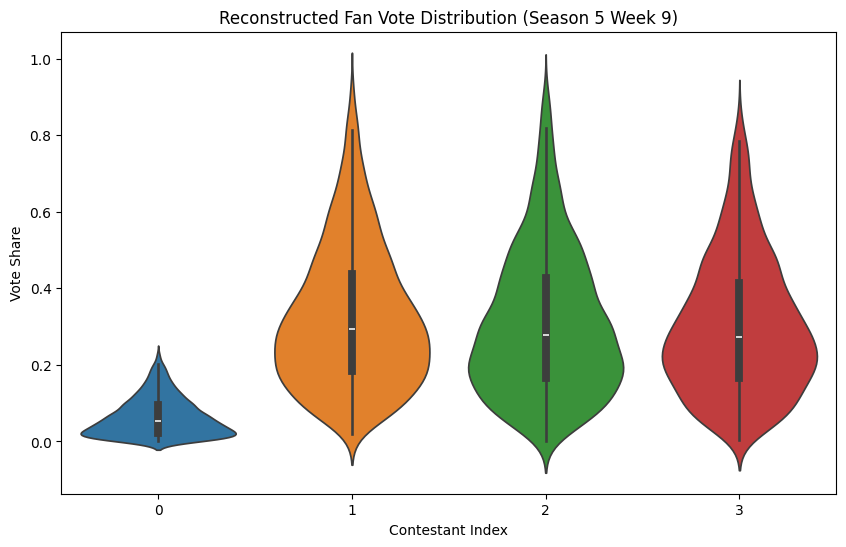

In [10]:
# 示例：第5季第9周 Jennie Garth 淘汰分析 (百分比法)
scores = [29, 28, 30, 30]
eliminated = 0
reconstructor = FanVoteReconstructor(scores, eliminated, method='percentage')
samples = reconstructor.hit_and_run(n_samples=2000, thinning=5)

if samples is not None:
    print(f"Jennie Garth 平均估计得票率: {np.mean(samples[:, 0]):.2%}")
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=samples)
    plt.title('Reconstructed Fan Vote Distribution (Season 5 Week 9)')
    plt.xlabel('Contestant Index')
    plt.ylabel('Vote Share')
    plt.show()

## 可选：从数据集中抽取某季某周进行重构
- 通过 `results` 字段定位淘汰周数
- 使用当周评委分数计算平均分作为 $J$

参与人数: 10，淘汰选手: Wayne Newton

【得票率后验均值 Top 10】
                 name     mean      p05      p95
     Cameron Mathison 0.127171 0.010389 0.381623
         Marie Osmond 0.119864 0.008149 0.336209
                Mel B 0.114205 0.006970 0.365679
Floyd Mayweather Jr.  0.109000 0.013131 0.288768
    Helio Castroneves 0.107404 0.007183 0.292988
         Jane Seymour 0.103547 0.005938 0.304102
         Jennie Garth 0.103521 0.008246 0.280056
        Sabrina Bryan 0.098453 0.007277 0.263213
           Mark Cuban 0.098037 0.013150 0.235418
         Wayne Newton 0.018798 0.001687 0.043411

淘汰选手平均估计得票率: 1.88%


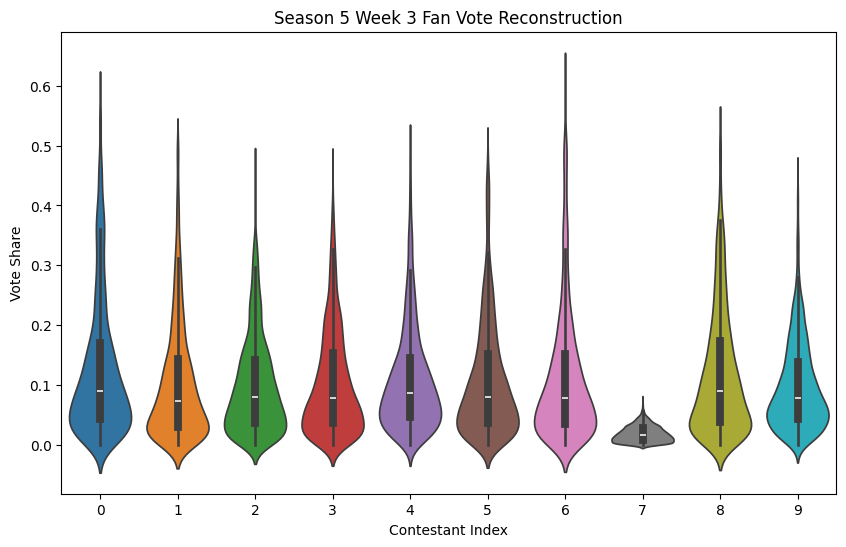

In [11]:
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'
df = pd.read_csv(DATA_PATH)

def extract_week_case_processed(frame, season, week_num):
    season_df = frame[frame['season'] == season].copy()
    avg_col = f'week{week_num}_avg_score'
    if avg_col not in season_df.columns:
        raise ValueError(f'未找到 {avg_col} 列')

    participants = season_df[season_df[avg_col].notna()].copy()
    if participants.empty:
        raise ValueError('该周无可用参赛选手数据')

    elim_mask = participants['weeks_survived'] == week_num
    if elim_mask.sum() == 0:
        raise ValueError('未找到该周淘汰选手（可能是双淘汰或数据缺失）')

    eliminated_name = participants.loc[elim_mask, 'celebrity_name'].iloc[0]
    participants = participants.reset_index(drop=True)
    eliminated_idx = participants.index[participants['celebrity_name'] == eliminated_name][0]

    scores = participants[avg_col].tolist()
    names = participants['celebrity_name'].tolist()
    return scores, names, eliminated_idx

# 示例：选择一个赛季与周次
season = 5
week = 3
scores, names, eliminated_idx = extract_week_case_processed(df, season, week)
print(f'参与人数: {len(scores)}，淘汰选手: {names[eliminated_idx]}')

reconstructor = FanVoteReconstructor(scores, eliminated_idx, method='percentage')
samples = reconstructor.hit_and_run(n_samples=3000, thinning=5)

if samples is not None:
    mean_votes = samples.mean(axis=0)
    ci_low = np.quantile(samples, 0.05, axis=0)
    ci_high = np.quantile(samples, 0.95, axis=0)
    summary = pd.DataFrame({
        'name': names,
        'mean': mean_votes,
        'p05': ci_low,
        'p95': ci_high
    }).sort_values('mean', ascending=False)

    print('\n【得票率后验均值 Top 10】')
    print(summary.head(10).to_string(index=False))

    elim_vote = mean_votes[eliminated_idx]
    print(f"\n淘汰选手平均估计得票率: {elim_vote:.2%}")

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=samples)
    plt.title(f'Season {season} Week {week} Fan Vote Reconstruction')
    plt.xlabel('Contestant Index')
    plt.ylabel('Vote Share')
    plt.show()